In [70]:
# Standard libraries
from datetime import datetime as dt
from datetime import timedelta as td
import pickle
import warnings

# Data manipulation and analysis libraries
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as sm
from scipy.stats import ttest_ind
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


# Machine learning and deep learning libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import xgboost as xgb



# Data visualization libraries
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)


date_competition = dt(2021, 7, 2)  # Fecha de la llegada de la competencia

In [2]:

def lineplot_movingaverage_pattern(
    df: pd.DataFrame, var: str = "", filtval=None, avg_days: int = 1
) -> None:
    """
    Gráfico para visualizar patrones de demanda en el año para
    los registros que coincidan con el filtro construido a partir
    de var y fitval.
    La demanda es graficada en su media móvil para los días especificados
    en avg_days

    Parameters
    ----------
    df: Dataframe que se desea filtrar
    var: nombre de columna en df
    fitval: valor de la columna para filtrar

    Returns
    -------
    None

    """
    filt_df = df if filtval == "" else df[df[var] == filtval]
    filt_df.demanda = filt_df.demanda.rolling(avg_days).mean()
    plt.figure(figsize=(15, 6))
    sns.lineplot(x="month_day", y="demanda", hue="year", data=filt_df)
    plt.title(f"Lineplot month pattern for {var} == {filtval}")
    plt.xlabel("month_day")
    plt.ylabel("demanda")
    x_ticks = filt_df["month_day"].unique()[::avg_days]
    plt.xticks(x_ticks, rotation=45)
    plt.axvline(x="07-02", color='red', linestyle='--', linewidth=2)
    plt.grid()
    plt.show()


def barplot_month_pattern(df: pd.DataFrame, var: str = "", filtval=None) -> None:
    """
    Gráfico de barras que muestra las ventas totales por mes.

    Gráfico para visualizar patrones de demanda en el año para
    los registros que coincidan con el filtro construido a partir
    de var y fitval.
    

    Parameters
    ----------
    df: Dataframe que se desea filtrar
    var: nombre de columna en df
    fitval: valor de la columna para filtrar

    Returns
    -------
    None

    """
    filt_df = df if filtval == "" else df[df[var] == filtval]
    filt_df = filt_df[["month","year","demanda"]]
    filt_df = filt_df.groupby(["year","month"]).sum().reset_index()
    plt.figure(figsize=(15, 6))
    sns.barplot(x="month", y="demanda", hue="year", data=filt_df)
    plt.title(f"Lineplot month pattern for {var} == {filtval}")
    plt.xlabel("month")
    plt.ylabel("demanda")
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()


def lineplot_weekday_pattern(df: pd.DataFrame, var: str = "", filtval=None) -> None:
    """
    Gráfico para visualizar patrones de demanda en la semana para
    los registros que coincidan con el filtro construido a partir
    de var y fitval

    Parameters
    ----------
    df: Dataframe que se desea filtrar
    var: nombre de columna en df
    fitval: valor de la columna para filtrar

    Returns
    -------
    None

    """
    filt_df = df if filtval == "" else df[df[var] == filtval]
    filt_df = filt_df[["month","day","demanda"]]
    filt_df = filt_df.groupby(["day","month"]).mean().reset_index()


    plt.figure(figsize=(15, 15))
    sns.lineplot(x="day", y="demanda", hue="month", data=filt_df,linewidth=3)
    plt.title(f"Lineplot week pattern for {var} == {filtval}")
    plt.xlabel("day")
    plt.ylabel("demanda")
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()


def compute_rmse(test_df):
    sq_difference = (test_df["demanda_pred"]-test_df["demanda"])**2
    mean_sq_difference = (sq_difference/test_df.shape[0]).sum()
    rmse = mean_sq_difference**(1/2)
    return rmse

In [3]:
df_products = pd.read_csv("data/catalogo_productos.csv")
df_demand_train= pd.read_csv("data/demanda.csv",parse_dates=["date"])
df_demand_test = pd.read_csv("data/demanda_test.csv",parse_dates=["date"])

# Data Processing

## Missing Values

In [4]:
df_products.isna().sum().sort_values(ascending=False)

subcategoria       32
premium             5
tamaño              3
nit_proveedor       1
id_producto         0
categoria           0
marca_exclusiva     0
estacional          0
dtype: int64

Hay bastatentes valores faltantes en la tabla de productos:

- 32 valores faltantes en la variable "subcategoria"
- 5 valores faltantes en la variable "premium"
- 3 valores faltantes en la variable "tamaño"
- 1 valore faltantes en la variable "nit_proveedor"

Mi primer acercamiento sería consultar con la fuente directa de los datos para consultar por los valores faltantes, pero cómo en este caso no se presenta esa posibilidad, busco la manera de llenar los datos faltantes a cómo de lugar.

Si los registros faltantes fueran dados en variables numéricas, o categóricas ordinales, utilizaría un método de imputación basado en las demás variables, cómo por ejemplo "IterativeImputer" de ScikitLearn; pero cómo la mayoría de valores faltantes se dan en "subcategoria", y  "premium", esta segunda aproximación se hace menos viable.

Dicho esto, se llenarán los valores faltantes haciendo una imputación manual basada en la relación de las variables faltantes con los registros presentes en otras categorías similares.

### Missing values in "subcategoria"

In [5]:
missing_subcategoria_df = df_products[df_products["subcategoria"].isna()]
display(missing_subcategoria_df.sample(5))
missing_subcategoria_df.categoria.unique()

,id_producto,categoria,subcategoria,tamaño,premium,marca_exclusiva,estacional,nit_proveedor
109,110,productos_enlatados_y_alimentos_envasados,NaN,Pequeño,0.0,0,0,890900667.0
32,33,productos_enlatados_y_alimentos_envasados,NaN,Pequeño,0.0,1,1,890900667.0
129,130,productos_enlatados_y_alimentos_envasados,NaN,Pequeño,1.0,1,0,890900667.0
133,134,productos_enlatados_y_alimentos_envasados,NaN,Pequeño,0.0,1,0,890900667.0
55,56,productos_enlatados_y_alimentos_envasados,NaN,Mediano,0.0,0,0,890900667.0


array(['productos_enlatados_y_alimentos_envasados', 'aseo', 'bebidas',
       'productos_lacteos', 'frutas_y_verduras', 'shampoos',
       'panaderia_y_panificados', 'congelados', 'carnes_y_aves'],
      dtype=object)

Se imputarán strings vacíos ("") debido a que esta categoría sólo podría ser llenada con valores provenientes de la fuente original de los datos. Hacer asumpciones en esta variable puede traer un riesgo de sesgo indeseado

In [6]:
df_products.loc[missing_subcategoria_df.index,"subcategoria"] = ""

### Missing values in "premium"

In [7]:
missing_premium_df = df_products[df_products["premium"].isna()]
missing_premium_df

,id_producto,categoria,subcategoria,tamaño,premium,marca_exclusiva,estacional,nit_proveedor
1,2,jabones,Antibacterial,Pequeño,NaN,0,0,890900667.0
15,16,productos_lacteos,Leche,Mediano,NaN,0,0,890900667.0
85,86,bebidas,Cerveza Internacional,NaN,NaN,1,1,890900667.0
122,123,carnes_y_aves,Pollo,Pequeño,NaN,0,0,890900667.0
123,124,carnes_y_aves,Pollo,Pequeño,NaN,1,0,890900667.0


- Categoría "jabones","Antibacterial" contrastada con valores en "premium" de categorías "shampoos" y "aseo" -> La mayoría con valor premium == 0.0 ∴ en categoría "jabones" premium = 0

- Categoría "productos_lacteos","Leche" contrastada con valores en "premium" de categorías "bebidas", en subcategoría diferente a productos alicorados ("Cerveza Internacional","Licor Nacional","Vinos") -> La mayoría con valor premium == 0.0 ∴ en categoría "productos_lacteos" premium = 0

- Categoría "bebidas","Cerveza Internacional" contrastada con valores en "premium" de categorías "bebidas", en subcategoría "Cerveza Internacional" -> Todas con valor premium == 0.0 ∴ en categoría "bebidas","Cerveza Internacional" premium = 0

- Categoría "carnes_y_aves","Pollo" contrastada con valores en "premium" de categorías "carnes_y_aves","Pollo" -> Todas con valor premium == 0.0 independiente del tamaño ∴ en categoría "carnes_y_aves","Pollo" premium = 0

In [8]:
df_products.loc[missing_premium_df.index,"premium"] = 0

### Missing values in "tamaño"

In [9]:
missing_tamaño_df = df_products[df_products["tamaño"].isna()]
missing_tamaño_df

,id_producto,categoria,subcategoria,tamaño,premium,marca_exclusiva,estacional,nit_proveedor
22,23,productos_lacteos,Yogur,NaN,0.0,1,0,890900667.0
30,31,carnes_y_aves,Pavo,NaN,0.0,0,0,890900667.0
85,86,bebidas,Cerveza Internacional,NaN,0.0,1,1,890900667.0


- Categoría "productos_lacteos","Yogur" contrastada con valores en "tamaño" de categorías "productos_lacteos" -> La mayoría con valor tamaño == Pequeño ∴ en categoría "productos_lacteos","Yogur" tamaño = Pequeño

- Categoría "carnes_y_aves","Pavo" contrastada con valores en "tamaño" de categorías "carnes_y_aves","Pavo" -> Todos con valor tamaño == Pequeño ∴ en categoría "carnes_y_aves","Pavo" tamaño = Pequeño

- Categoría "bebidas","Cerveza Internacional" contrastada con valores en "tamaño" de categorías "bebidas","Cerveza Internacional" -> Todos con valor tamaño == Pequeño ∴ en categoría "bebidas","Cerveza Internacional" tamaño = Pequeño

In [10]:
df_products.loc[missing_tamaño_df.index,"tamaño"] = "Pequeño"

### Missing values in "nit_proveedor"

In [11]:
missing_nit_proveedor_df = df_products[df_products["nit_proveedor"].isna()]
display(missing_nit_proveedor_df)
others_nit_df = df_products[df_products.categoria=="productos_enlatados_y_alimentos_envasados"]
others_nit = others_nit_df.nit_proveedor.unique()
others_nit

,id_producto,categoria,subcategoria,tamaño,premium,marca_exclusiva,estacional,nit_proveedor
59,60,productos_enlatados_y_alimentos_envasados,,Pequeño,0.0,0,0,NaN


array([8.90900667e+08,            nan])

- El proveedor de todos los productos en categoría "productos_enlatados_y_alimentos_envasados" es el mismo ∴ se asigna dicho nit de proveedor (890900667.0) a esta registro faltante

In [12]:
df_products.loc[missing_nit_proveedor_df.index,"nit_proveedor"] = others_nit[0]

## Data Format and Type

Se ajustó el tipo de dato más apropiada para cada variable

- categoria cambió de string a categoría sin valor ordinal
- subcategoria cambió de string a categoría sin valor ordinal, el formato de texto fue además cambiado a snake casing para estar en concordancia con el formato en categoria
- tamaño cambió de string a categoría con valor ordinal: 'pequeño' < 'mediano' < 'grande'
- premium cambió de float a booleano
- marca_exclusiva cambió de int a booleano
- estacional cambió de int a booleano
- nit_proveedor cambió de float a categoría sin valor ordinal

In [13]:
df_products.head(5)

,id_producto,categoria,subcategoria,tamaño,premium,marca_exclusiva,estacional,nit_proveedor
0,1,bebidas,Agua,Mediano,0.0,1,0,890900667.0
1,2,jabones,Antibacterial,Pequeño,0.0,0,0,890900667.0
2,3,bebidas,Gaseosa,Pequeño,0.0,1,0,890900667.0
3,4,congelados,Vegetales,Pequeño,0.0,1,1,890900667.0
4,5,shampoos,Acondicionador,Pequeño,0.0,1,0,890900667.0


In [14]:
df_products.categoria = df_products.categoria.astype('category')

df_products.subcategoria = df_products.subcategoria.apply(lambda x: x.lower().replace(" ","_"))
df_products.subcategoria = df_products.subcategoria.astype('category')

df_products.tamaño = df_products.tamaño.apply(lambda x: x.lower())
df_products['tamaño'] = pd.Categorical(df_products['tamaño'], categories=['pequeño','mediano', 'grande'], ordered=True)

df_products.premium = df_products.premium.astype(int).astype(bool)
df_products.marca_exclusiva = df_products.marca_exclusiva.astype(bool)
df_products.estacional = df_products.estacional.astype(bool)
df_products.nit_proveedor = df_products.nit_proveedor.astype(int).astype('category')


df_demand_train["year"] = df_demand_train.date.dt.year
df_demand_train["month"] = df_demand_train.date.dt.month_name()
month_order = list(df_demand_train.month.unique())
df_demand_train["month"] = pd.Categorical(df_demand_train.date.dt.month_name(), categories=month_order, ordered=True)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_demand_train["day"] = pd.Categorical(df_demand_train.date.dt.day_name(), categories=day_order, ordered=True)
df_demand_train['month_day'] = df_demand_train['date'].dt.strftime('%m-%d')


## Adding Relevent Features

Se agregó una variable booleana adicional "after_competition", que ayudará a diferenciar el momento en que ingresó la competencia al mercado, el 2 de julio del 2021

In [15]:
df_demand_train["after_competition"] = df_demand_train.date>=date_competition

## Irrelevant Data

La columna nit_proveedor tiene el mismo valor en todos los regitros, haciéndola una variable poco relevante para el objetivo del modelo de predicción.

In [16]:
df_products = df_products.drop(columns=["nit_proveedor"])

## Merge

In [17]:
df_demand_test = df_demand_test.merge(df_products,left_on="id_producto",right_on="id_producto",how="left")
df_demand_train = df_demand_train.merge(df_products,left_on="id_producto",right_on="id_producto",how="left")

# EDA

Se inicia haciendo una comparación generalizada de la demanda 1 año antes y 1 año después de la entrada de la competencia el 2 de julio del 2021.

A simple vista se objserva una tendencia a la baja de la demanda de los productos desde que llegó la competencia.

nota: se graficó la media móvil a 30 días para visualizar con mayor facilidad el patrón de la demanda en el tiempo

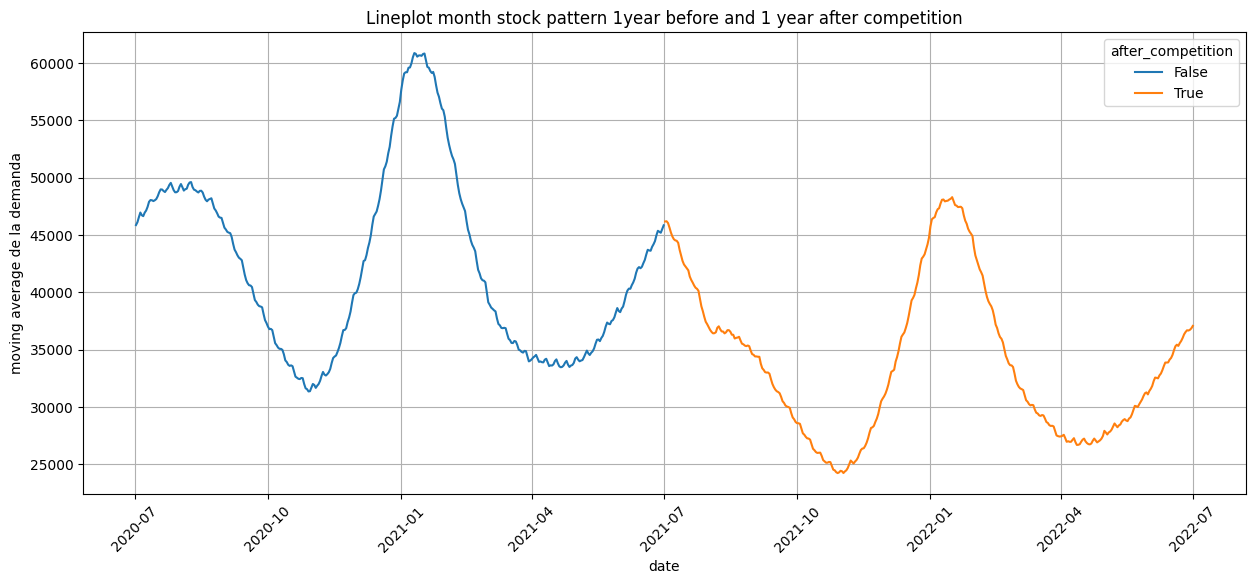

In [18]:
overall_trend_df = df_demand_train[["date","demanda"]].groupby("date").sum().reset_index()
overall_trend_df["after_competition"] = overall_trend_df.date>=date_competition
overall_trend_df["30day_mov_avg"] = overall_trend_df.demanda.rolling(30).mean()

overall_trend_1ybefore_df = overall_trend_df[overall_trend_df.after_competition==False].iloc[-365:]
overall_trend_1yafter_df = overall_trend_df[overall_trend_df.after_competition].iloc[:365]
overall_trend_2y_df = pd.concat([overall_trend_1ybefore_df,overall_trend_1yafter_df])

plt.figure(figsize=(15, 6))
sns.lineplot(x="date", y="30day_mov_avg", hue="after_competition", data=overall_trend_2y_df)
plt.title(f"Lineplot month stock pattern 1year before and 1 year after competition")
plt.xlabel("date")
plt.ylabel("moving average de la demanda")
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [19]:
overall_trend_1ybefore_df.demanda.quantile([.25, .5, .75])

0.25    35007.0
0.50    41504.0
0.75    48410.0
Name: demanda, dtype: float64

In [20]:
overall_trend_1yafter_df.demanda.quantile([.25, .5, .75])

0.25    27906.0
0.50    32768.0
0.75    37688.0
Name: demanda, dtype: float64

Con el diagrama de Cajas se hace evidente con mayor facilidad una importante reducción de la demanda de los productos después de la llegada de la competencia. 
- El año antes de la competencia se contaba con una demanda en una mediana de 41500 productos (Q1=35000,Q3=48400)
- Después de la cometencia se cuenta una mediana de 32700 (Q1=27900,Q3=37600)

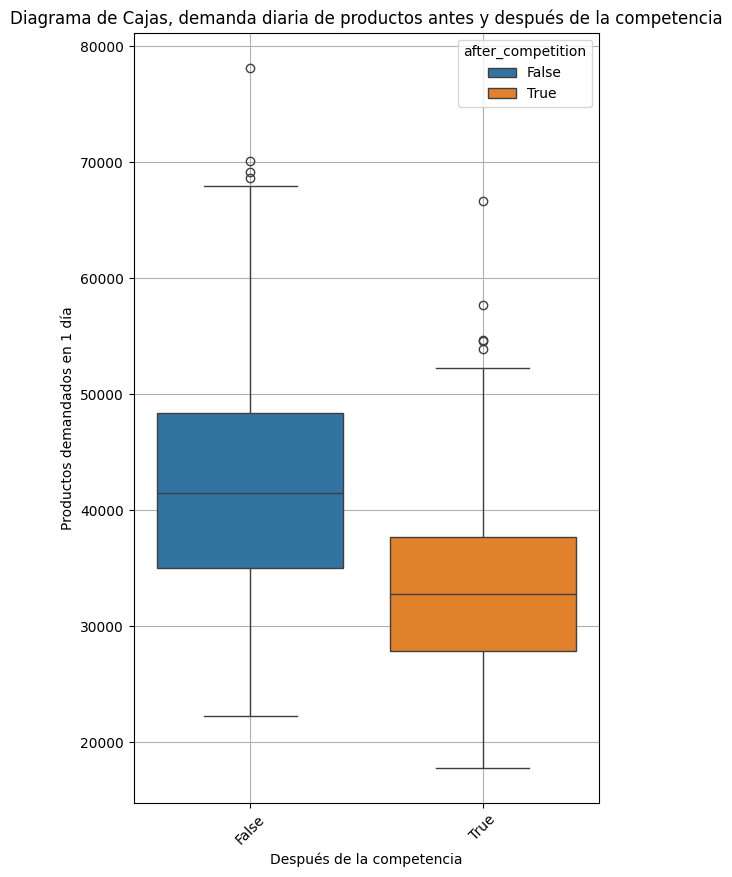

In [21]:
plt.figure(figsize=(6, 10))
sns.boxplot(data=overall_trend_2y_df, x="after_competition", y="demanda",hue="after_competition")
plt.title(f"Diagrama de Cajas, demanda diaria de productos antes y después de la competencia")
plt.xlabel("Después de la competencia")
plt.ylabel("Productos demandados en 1 día")
plt.xticks(rotation=45)
plt.grid()
plt.show()

Para comprobar que esta diferencia es estadísticamente significativa, se procedió a realizar un t-test sobre la demanda de productos antes y después del 2 de julio del 2021, tomando cómo:

- Hipótesis nula (H0): no existe diferencia en la demanda entre antes y después de la llegada de la competencia
- Hipótesis alternativa (Ha): sí existe una diferencia significativa entre la demanda antes y después de la llegada de la competencia

Se obtuvo como resultado un p-value mucho menor que 0.05, por lo que se rechaza la hipótesis nula, y se concluye que dicha diferencia sí es significativa, y que corresponde con alrededor de una pérdida de 41504.0-32768.0 = 8736 productos diarios en la mediana

In [22]:
ttest_ind(overall_trend_1ybefore_df.demanda, overall_trend_1yafter_df.demanda)

TtestResult(statistic=13.918088276062297, pvalue=3.237331780181677e-39, df=728.0)

Respecto de la pérdida por categoría de producto, se observa el gráfico de caja y la tabla dónde se pueden ver visualmente y de forma tangible las diferencias estadísticas de demanda antes y después de la llegada de la competencia.

Los productos que mayor cantidad de demanda perdió fueron:

1° productos_lacteos, con una diferencia de 3472 unidades

2° bebidas, con una diferencia de 2042 unidades

3° aseo, con una diferencia de 1097 unidades

4° carnes_y_aves, con una diferencia de 1016 unidades

demanda_pos                \
                                                count          mean   
categoria                                                             
aseo                                            366.0   1167.150273   
bebidas                                         366.0  10180.592896   
carnes_y_aves                                   366.0   5717.754098   
cereales_y_productos_secos                      366.0   2888.311475   
congelados                                      365.0    417.208219   
frutas_y_verduras                               366.0    786.543716   
jabones                                         348.0    345.410920   
panaderia_y_panificados                         366.0    709.683060   
productos_enlatados_y_alimentos_envasados       366.0   6152.644809   
productos_lacteos                               366.0   3118.281421   
shampoos                                        366.0   2029.655738   

                                                                         \
                                                   std     min      25%   
categoria                                                                 
aseo                                        283.852763   392.0   975.00   
bebidas                                    2323.259122  5104.0  8416.00   
carnes_y_aves                              1466.363837  2694.0  4606.75   
cereales_y_productos_secos                  937.165541  1154.0  2252.25   
congelados                                  200.659491    89.0   287.00   
frutas_y_verduras                           208.976257   225.0   636.50   
jabones                                      93.092626   166.0   280.00   
panaderia_y_panificados                     191.114720    69.0   582.25   
productos_enlatados_y_alimentos_envasados  1434.135837  3268.0  5143.75   
productos_lacteos                           864.868497  1508.0  2440.00   
shampoos                                    414.605674  1056.0  1725.25   

                                                                      \
                                              50%       75%      max   
categoria                                                              
aseo                                       1148.5   1327.75   2887.0   
bebidas                                    9950.5  11481.50  18898.0   
carnes_y_aves                              5582.0   6687.75  12341.0   
cereales_y_productos_secos                 2667.0   3336.25   7007.0   
congelados                                  357.0    488.00   1032.0   
frutas_y_verduras                           791.5    932.50   1501.0   
jabones                                     333.5    398.25    810.0   
panaderia_y_panificados                     703.0    844.00   1333.0   
productos_enlatados_y_alimentos_envasados  6033.0   6969.50  11677.0   
productos_lacteos                          3049.5   3616.75   7595.0   
shampoos                                   2025.0   2321.50   3250.0   

                                          demanda_pre                \
                                                count          mean   
categoria                                                             
aseo                                            365.0   2322.780822   
bebidas                                         365.0  12399.821918   
carnes_y_aves                                   365.0   6722.243836   
cereales_y_productos_secos                      365.0   2907.967123   
congelados                                      363.0    525.859504   
frutas_y_verduras                               365.0   1063.578082   
jabones                                         340.0    387.600000   
panaderia_y_panificados                         365.0    893.852055   
productos_enlatados_y_alimentos_envasados       365.0   6171.167123   
productos_lacteos                               365.0   6604.328767   
shampoos                                        365.0   2435.863

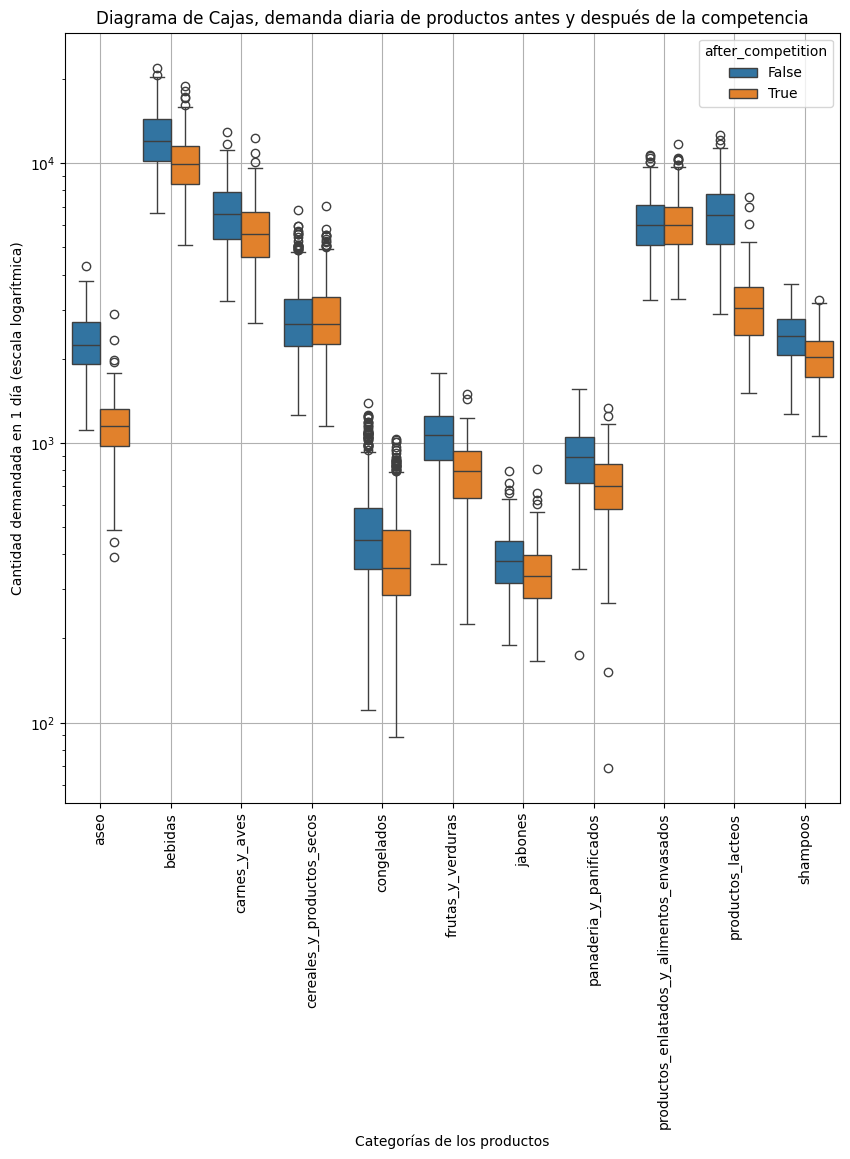

categoria
productos_lacteos                            3472.0
bebidas                                      2042.0
aseo                                         1098.0
carnes_y_aves                                1016.0
shampoos                                      382.0
frutas_y_verduras                             272.0
panaderia_y_panificados                       185.0
congelados                                     93.0
jabones                                        44.0
cereales_y_productos_secos                      4.0
productos_enlatados_y_alimentos_envasados     -36.0
dtype: float64

In [23]:
cat_trend_df = df_demand_train[["categoria", "demanda","date"]].groupby(["date","categoria"], observed=True).sum().reset_index().sort_values(by="demanda", ascending=False)
cat_trend_df["after_competition"] = cat_trend_df.date>=date_competition

cat_trend_1ybefore_df = cat_trend_df[(cat_trend_df.after_competition==False) & (cat_trend_df.date>=(date_competition-td(days=365)))]
cat_trend_1yafter_df = cat_trend_df[cat_trend_df.after_competition & (cat_trend_df.date<=(date_competition+td(days=365)))]
cat_trend_2y_df = pd.concat([cat_trend_1ybefore_df,cat_trend_1yafter_df])

dempercat_pos_df = cat_trend_1yafter_df[["categoria",	"demanda"]].groupby("categoria",observed=True).describe()
dempercat_pre_df = cat_trend_1ybefore_df[["categoria",	"demanda"]].groupby("categoria",observed=True).describe()
dempercat_comp_df = pd.merge(dempercat_pos_df,dempercat_pre_df,left_index=True,right_index=True,how="inner",suffixes=("_pos","_pre"))
display(dempercat_comp_df)

plt.figure(figsize=(10, 10))
sns.boxplot(data=cat_trend_2y_df, x="categoria", y="demanda",hue="after_competition")
plt.title(f"Diagrama de Cajas, demanda diaria de productos antes y después de la competencia")
plt.xlabel("Categorías de los productos")
plt.ylabel("Cantidad demandada en 1 día (escala logarítmica)")
plt.yscale('log')
plt.xticks(rotation=90)
plt.grid()
plt.show()

perdidas_s = dempercat_comp_df.loc[:,("demanda_pre","50%")]-dempercat_comp_df.loc[:,("demanda_pos","50%")]
perdidas_s = perdidas_s.sort_values(ascending=False).round()
display(perdidas_s)

En la siguiente gráfica se visualiza la demanda por cada categoría de productos en millones, antes y después de la entrada del competidor el 2 de julio de 2021. Adicionalmente se superpuso una línea roja, que representa el porcentaje de pérdidas en demanda por cada una de estas categorías dadas desde que entró la competencia.

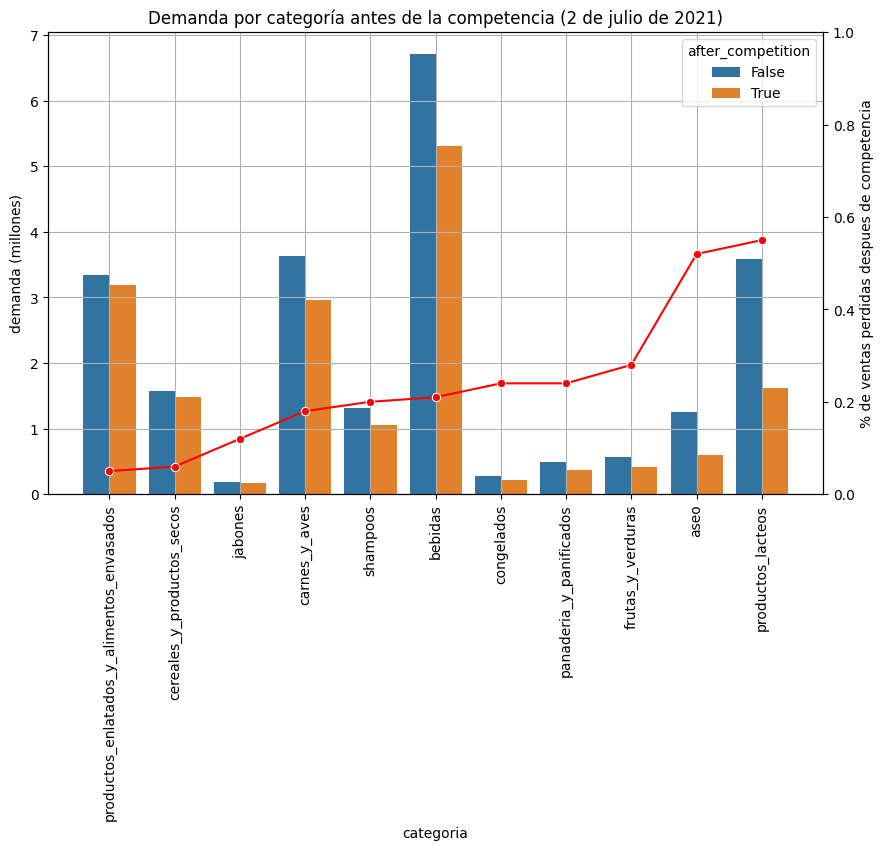

demanda            \
after_competition                             False      True   
categoria                                                       
productos_enlatados_y_alimentos_envasados  3.346185  3.185199   
cereales_y_productos_secos                 1.573200  1.484366   
jabones                                    0.193624  0.169496   
carnes_y_aves                              3.629891  2.967250   
shampoos                                   1.318259  1.052049   
bebidas                                    6.708777  5.302729   
congelados                                 0.278603  0.211295   
panaderia_y_panificados                    0.487626  0.369252   
frutas_y_verduras                          0.574420  0.412291   
aseo                                       1.259919  0.605534   
productos_lacteos                          3.581293  1.620116   

                                          percent_dec_after  
after_competition                                            
categoria                                                    
productos_enlatados_y_alimentos_envasados              0.05  
cereales_y_productos_secos                             0.06  
jabones                                                0.12  
carnes_y_aves                                          0.18  
shampoos                                               0.20  
bebidas                                                0.21  
congelados                                             0.24  
panaderia_y_panificados                                0.24  
frutas_y_verduras                                      0.28  
aseo                                                   0.52  
productos_lacteos                                      0.55

In [24]:
overall_com_df = df_demand_train[["categoria", "demanda","after_competition"]].groupby(["after_competition","categoria"], observed=True).sum().reset_index().sort_values(by="demanda", ascending=False)
overall_com_df.demanda = overall_com_df.demanda/1e6

overall_com_pivot_df = overall_com_df.pivot(index='categoria', columns='after_competition', values=['demanda'])

demanda_after = overall_com_pivot_df.loc[:,("demanda",True)]
demanda_prev = overall_com_pivot_df.loc[:,("demanda",False)]

overall_com_pivot_df["percent_dec_after"] = ((demanda_prev-demanda_after)/demanda_prev).round(2)
overall_com_pivot_df = overall_com_pivot_df.sort_values(by="percent_dec_after")
category_order  = list(overall_com_pivot_df.index)


plt.figure(figsize=(10, 6))
sns.barplot(x='categoria', y='demanda', hue="after_competition",data=overall_com_df,order=category_order)
plt.title('Demanda por categoría antes de la competencia (2 de julio de 2021)')
plt.xlabel('categoria')
plt.ylabel('demanda (millones)')
plt.xticks(rotation=90)
plt.grid()

ax2 = plt.gca().twinx()
ax2.set_ylim(0, 1)
# Plot line plot on the twin Axes
sns.lineplot(x='categoria', y='percent_dec_after', data=overall_com_pivot_df, ax=ax2, color='red', marker='o')
ax2.set_ylabel('% de ventas perdidas despues de competencia')
plt.show()

display(overall_com_pivot_df)

Con la intención de realizar una exploración detallada de los patrones de ventas, se construyeron las funciones lineplot_movingaverage_pattern junto, barplot_month_pattern y lineplot_weekday_pattern. Las cuales permitirán con analizar los patrones de demanda de cualquier producto que se desee dentro de los datos.

lineplot_movingaverage_pattern: Gráfico de línea en los días del año, para los cuales se presenta la media móvil en los días que sean especificados

Aquí podemos evidenciar el fuerte impacto que tuvo la competencia en la demanda por productos lácteos. Tanto para el producto con id==23 (yogurt), cómo para la subcategoría entera de "leche",  se observa el efecto en la reducción de ventas desde la llegada de la competenicia el 2 de julio del 2021.

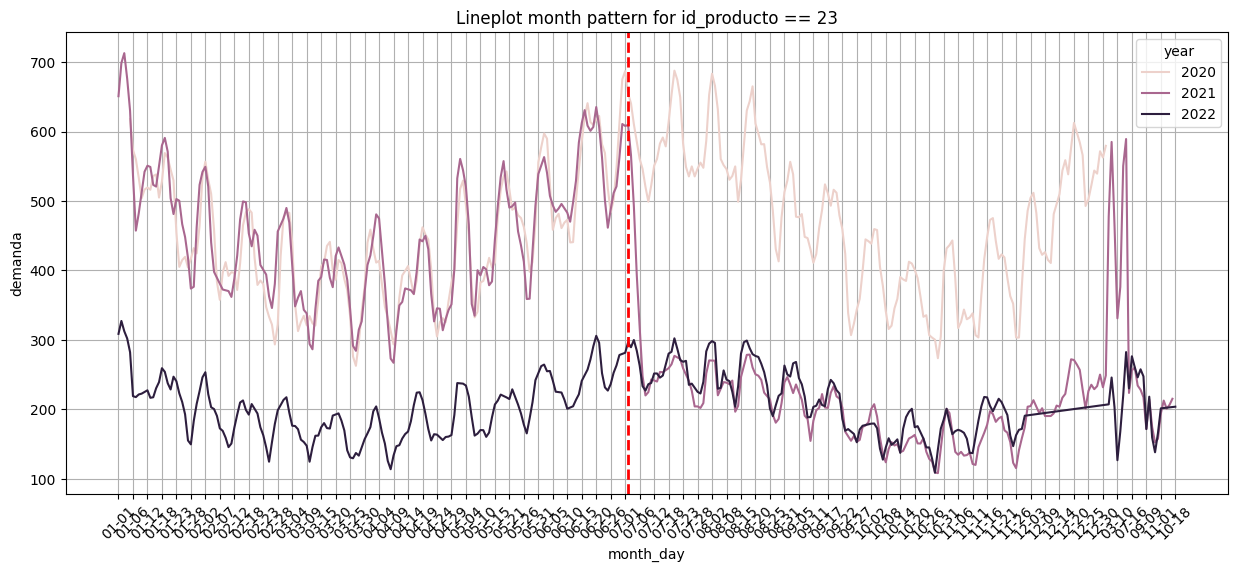

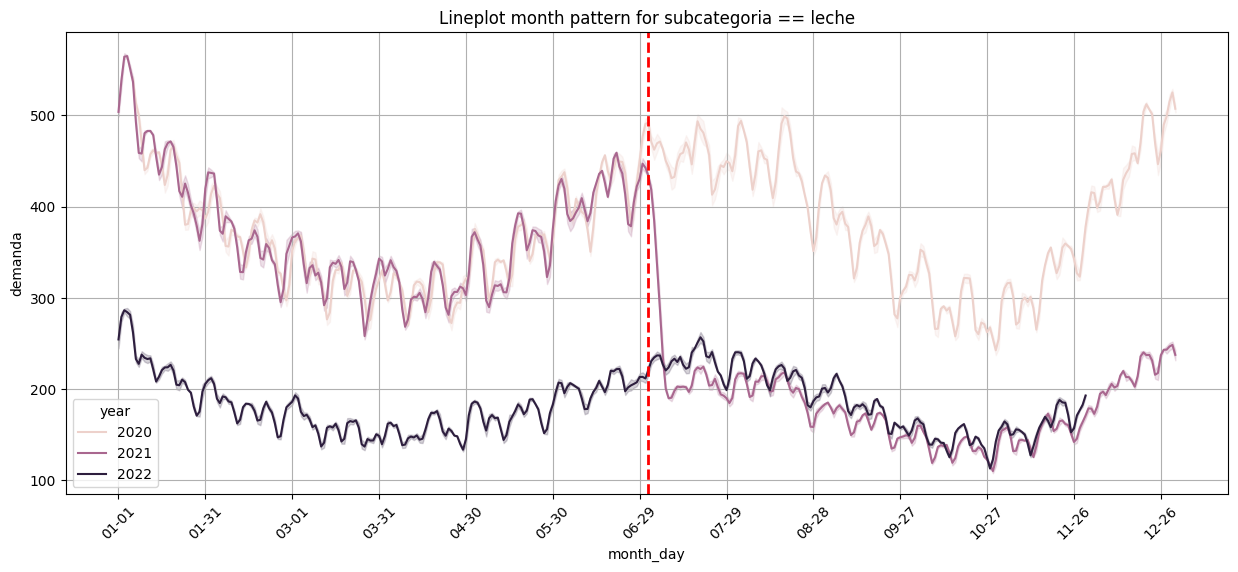

In [25]:
lineplot_movingaverage_pattern(df_demand_train,"id_producto",23,5)
lineplot_movingaverage_pattern(df_demand_train,"subcategoria","leche",30)

Mediante barplot_month_pattern se puede ver para los meses de los años disponibles en la base de datos, el total de las ventas conseguidas por mes, para el prodcto, categoría o subcategoría que sean especificados.

En los gráficos de abajo se objervan los patrones de ventas para productos estacionales y de marcas exclusivas. Podemos ver que hay una reducción importante de ventas para las marcas exclusivas, lo que puede significar que la competencia ofrece algún producto competitivo para estos, o incluso que puo haber llegado a tener accesibilidad de dichos productos para su venta.


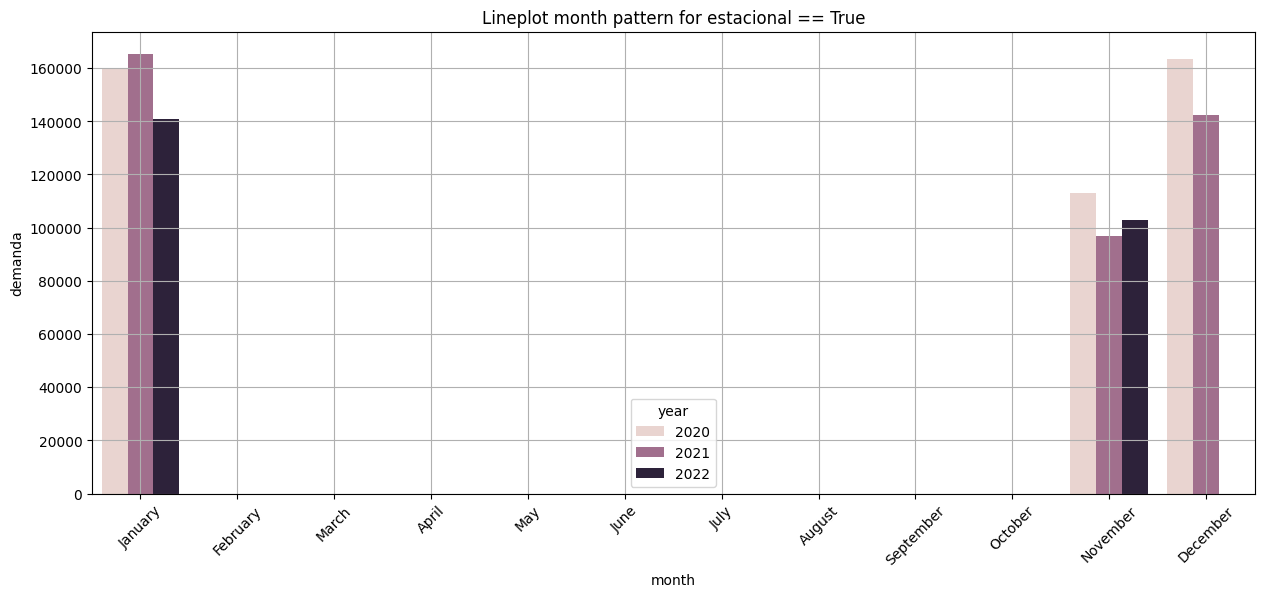

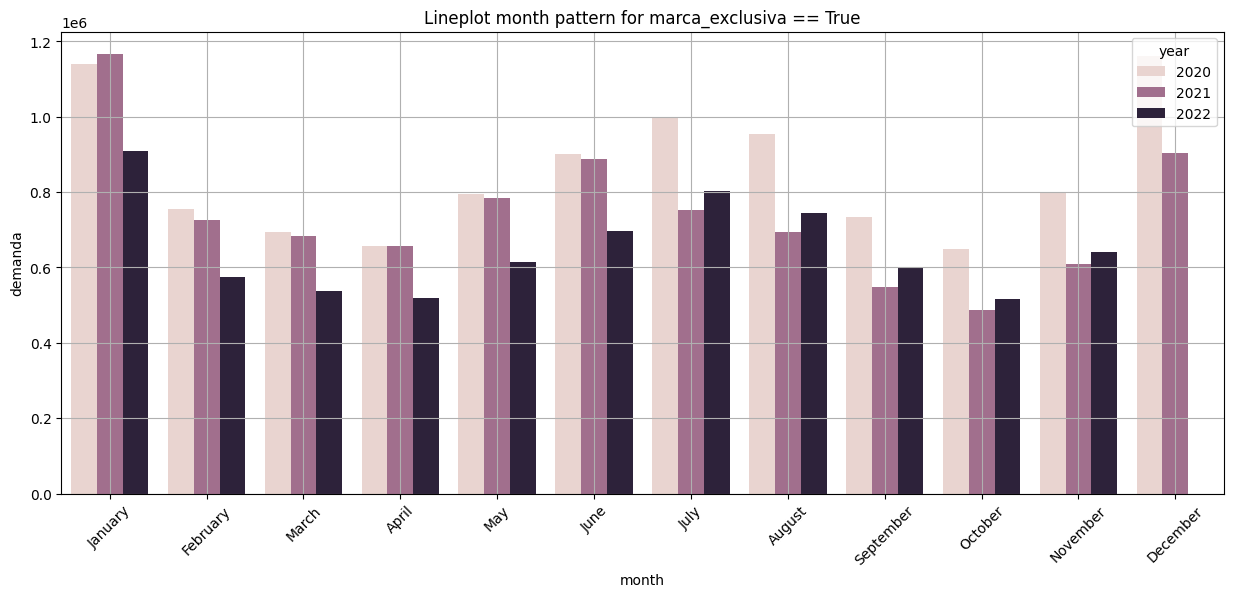

In [26]:
barplot_month_pattern(df_demand_train,"estacional",True)
barplot_month_pattern(df_demand_train,"marca_exclusiva",True)

Mediante lineplot_weekday_pattern se puede observar el patrón de promedio de ventas para los productos indicados a lo largo de los días de la semana para cada mes.

En el gráfico se observa la tendencia en el consumo de cerveza nacional a lo largo de la semana, teniendo su mínimo el lunes, y el pico en el día domingo. Asimismo su consumo es mayor en los primeros y últimos meses del año, y menor durante los meses de mitad de año.

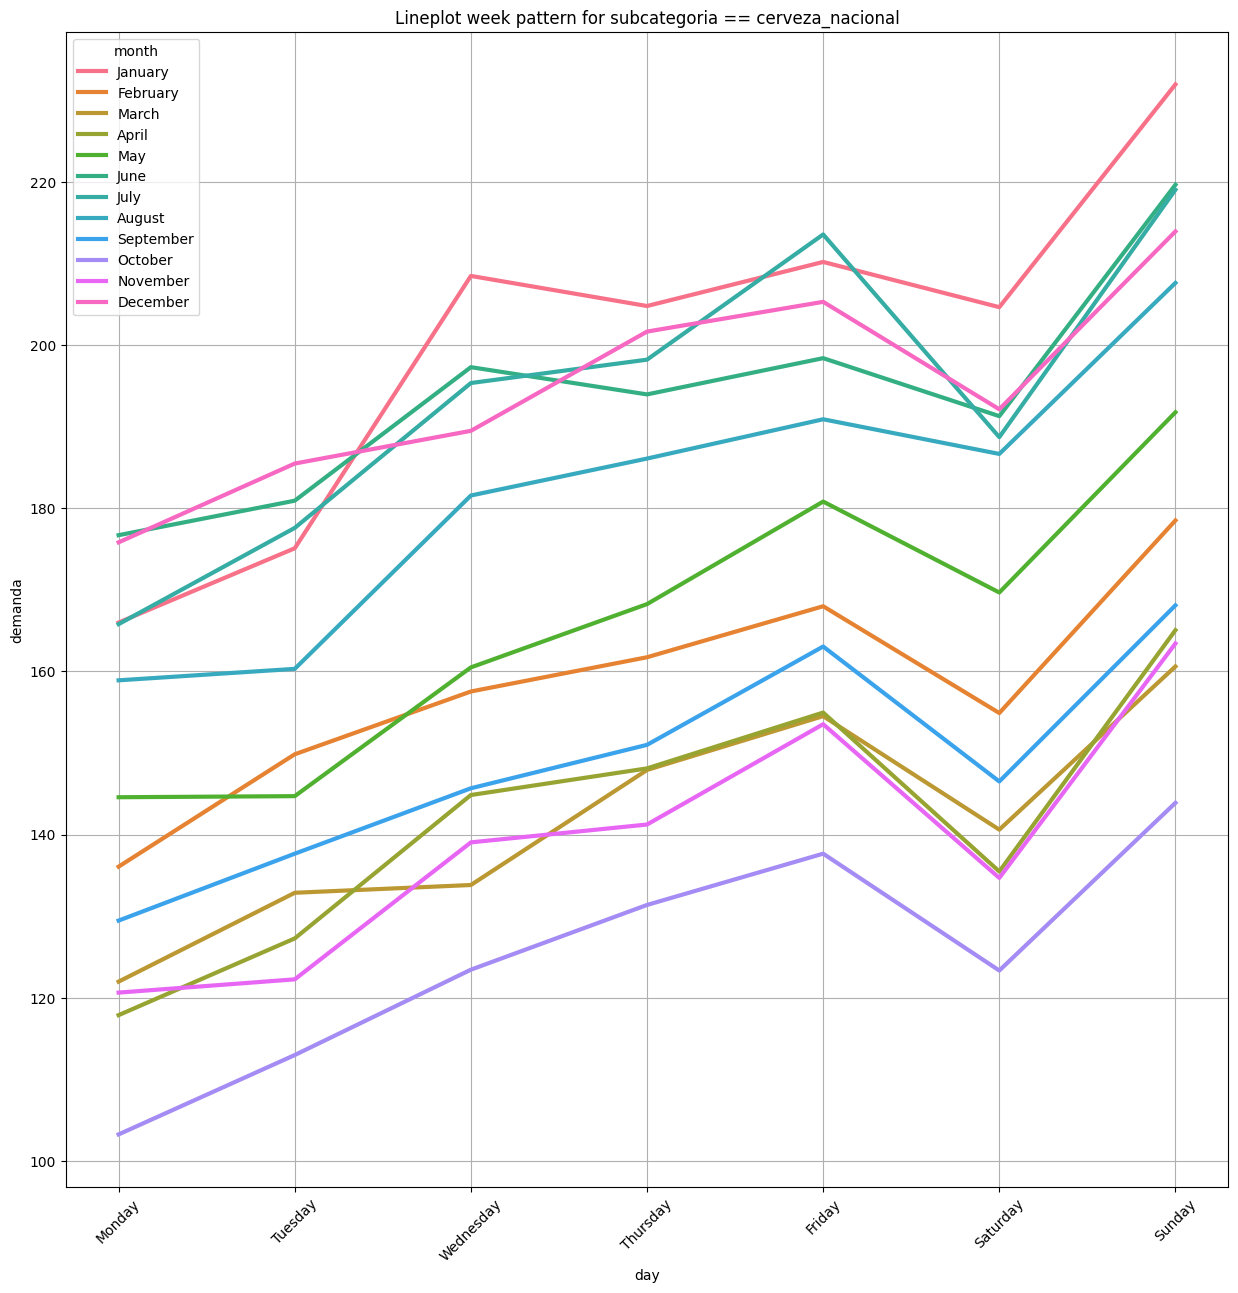

In [27]:
lineplot_weekday_pattern(df_demand_train,"subcategoria","cerveza_nacional")

Demanda total por categoría al paso de los años

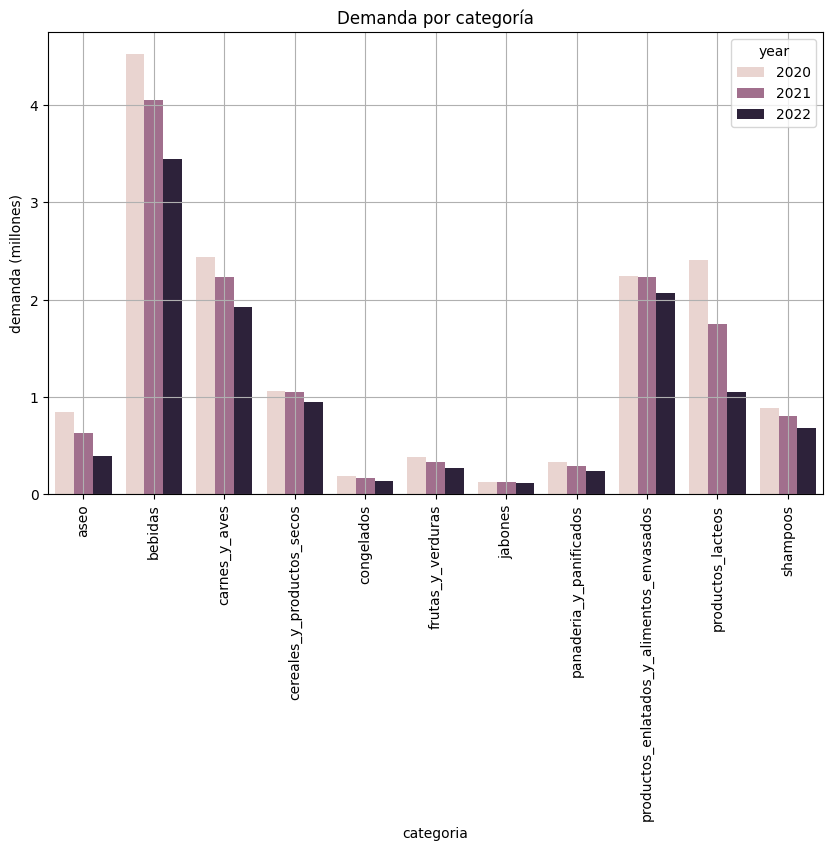

In [28]:
overall_dem_df = df_demand_train[["categoria", "demanda","year"]].groupby(["year","categoria"], observed=True).sum().reset_index().sort_values(by="demanda", ascending=False)
overall_dem_df.demanda = overall_dem_df.demanda/1e6
plt.figure(figsize=(10, 6))
sns.barplot(x='categoria', y='demanda', hue="year",data=overall_dem_df)
plt.title('Demanda por categoría')
plt.xlabel('categoria')
plt.ylabel('demanda (millones)')
plt.xticks(rotation=90)
plt.grid()
plt.show()


## Model

Se dividirán los datos de entrenamiento (demanda.csv) en entrenamiento y validación. Sobre la sección de entrenamiento se correrán diferentes modelos de regresión, y su desempeño será evaluado en la sección de validación. El mejor de todos será el seleccionado para correr las predicciones sobre los datos en demanda_test.csv.

demanda.csv contiene datos en un rango de tiempo total de 1064 días. Se tomará el primer 80% (851 días) de esos datos para entrenar el modelo, y el 20% (213 días) restante para validación

Se agregó una variable de especial interés para la efectividad del modelo: Conocimiento de la llegada de la competencia a partir del 2 de julio del 2021

In [29]:
df_demand_train["after_competition"] = df_demand_train.date>=date_competition

In [30]:
percent_train = 0.8
min_date = df_demand_train.date.min()
max_date = df_demand_train.date.max()
total_days = (max_date-min_date).days
total_days_08 = int(total_days*percent_train)
date_limit = min_date+td(days=total_days_08)
train , test = df_demand_train[df_demand_train.date<=date_limit],df_demand_train[df_demand_train.date>date_limit]

In [32]:
1/0

ZeroDivisionError: division by zero

### Linear Regression Approach

El mejor modelo que se consiguió mediante regresión lineal es el siguiente, el cual considera la fecha, todas las variables categóricas disponibles, y las relaciones que pueda haber entre ellas. De este modelo se puede adicionalmente determinar información adicional de la relación de las variables con la demanda.

De esta regresión se puede determinar que, manteniendo todas las variables contantes, mismo día del año, mismo producto y en su misma presentación, por cada año que pase hay una tendencia de una reducción en su demanda de 14 unidades (con un 95% de confiabilidad de que varía entre -19 y -10 unidades) diarias. Este resultado en el resumen de la regresión demuestra además que es un valor significativo (pvalue << 0.05)

```
                    coef    std err          t      P>|t|      [0.025      0.975]

year               -14.8473      2.493     -5.955      0.000     -19.734      -9.960
```

In [ ]:
train["categoria_subcategoria"] = train.categoria.astype(str)+"_"+train.subcategoria.astype(str)
test["categoria_subcategoria"] = test.categoria.astype(str)+"_"+test.subcategoria.astype(str)

train_lr = train.copy()
test_lr = test.copy()

formula = 'demanda ~ tamaño + after_competition + premium + marca_exclusiva + estacional + year + month + day + tamaño:premium + tamaño:marca_exclusiva + tamaño:estacional + tamaño:year + tamaño:month + tamaño:day + premium:marca_exclusiva + premium:estacional + premium:year + premium:month + premium:day + marca_exclusiva:estacional + marca_exclusiva:year + marca_exclusiva:month + marca_exclusiva:day + estacional:year + estacional:month + estacional:day + year:month + year:day + month:day + categoria_subcategoria + after_competition:premium + after_competition:marca_exclusiva + after_competition:estacional + after_competition:year + after_competition:month + after_competition:day'

linear_model = sm.ols(formula = formula, data = train_lr)
fitted_linear_model = linear_model.fit()
print(fitted_linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:                demanda   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     421.8
Date:                Fri, 03 May 2024   Prob (F-statistic):               0.00
Time:                        09:10:37   Log-Likelihood:            -6.4562e+05
No. Observations:              101403   AIC:                         1.292e+06
Df Residuals:                  101156   BIC:                         1.294e+06
Df Model:                         246                                         
Covariance Type:            nonrobust                                         
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

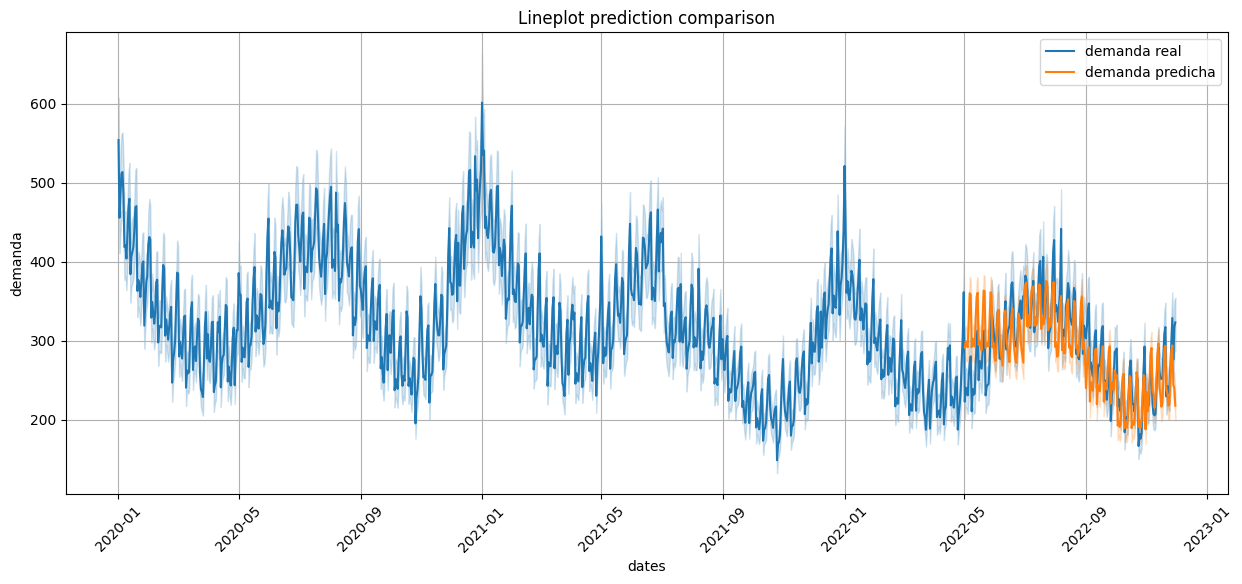

In [ ]:
test_lm = test_lr.copy()
test_lm["demanda_pred"] = fitted_linear_model.predict(test_lr)

plt.figure(figsize=(15, 6))
sns.lineplot(x="date", y="demanda", data=df_demand_train,label="demanda real")
sns.lineplot(x="date", y="demanda_pred", data=test_lm,label="demanda predicha")
plt.title(f"Lineplot prediction comparison")
plt.xlabel("dates")
plt.ylabel("demanda")
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [ ]:
rmse_lm = compute_rmse(test_lm)
rmse_lm

138.66480062709093

In [ ]:
with open(f'saved_models/lm_{rmse_lm:0.2f}.pkl', 'wb') as f:
    pickle.dump(fitted_linear_model, f)

### LSTM approach

In [46]:
def format_data(df_orig):
    df = df_orig.copy()
    df.year = df.date.dt.year
    df.month = df.date.dt.month
    df.day = df.date.dt.day
    dummies_id_producto = pd.get_dummies(df.id_producto)
    dummies_tamano = pd.get_dummies(df.tamaño)
    dummies_categoria_subcategoria = pd.get_dummies(df.categoria_subcategoria)

    df = pd.concat([df,dummies_id_producto,dummies_tamano,dummies_categoria_subcategoria],axis=1)

    dummies_id_producto_cols = dummies_id_producto.columns
    dummies_tamano_cols = dummies_tamano.columns
    dummies_categoria_subcategoria_cols = dummies_categoria_subcategoria.columns
    vars = ["year","month","day","after_competition","premium","marca_exclusiva","estacional"]
    vars = vars+list(dummies_id_producto_cols)+list(dummies_tamano_cols)+list(dummies_categoria_subcategoria_cols)

    x_df = df[vars].values
    num_vars = x_df.shape[1]

    scaler = MinMaxScaler()
    x_df_scaled = scaler.fit_transform(x_df)
    x_df_reshaped = x_df_scaled.reshape((x_df_scaled.shape[0], 1, x_df_scaled.shape[1]))
    return x_df_reshaped, num_vars

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(512, return_sequences=True, input_shape=input_shape))
    # model.add(Dropout(0.2))  # Add dropout regularization
    model.add(LSTM(256, return_sequences=True))
    # model.add(Dropout(0.2))  # Add dropout regularization
    model.add(LSTM(128, return_sequences=False))
    # model.add(Dropout(0.2))  # Add dropout regularization
    model.add(Dense(64, activation='linear'))  # Add a dense layer
    model.add(Dense(1))
    return model

In [ ]:


x_train_lstm, num_vars = format_data(train)
y_train_lstm = train[["demanda"]].values

num_obs = x_train_lstm.shape[1]
lstm_model = create_lstm_model((num_obs, num_vars))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
reduce_lr = ReduceLROnPlateau(
    monitor="loss", patience=2, factor=0.5, min_lr=0.00001, verbose=1
)
early_stopping = EarlyStopping(monitor="loss", patience=5, restore_best_weights=True,verbose=1)
lstm_model.fit(x_train_lstm, y_train_lstm, batch_size = 32, epochs=10,shuffle=True,callbacks=[reduce_lr, early_stopping])

Epoch 1/10
3169/3169 ━━━━━━━━━━━━━━━━━━━━ 71s 21ms/step - loss: 27590.7812 - learning_rate: 0.0010
Epoch 2/10
3169/3169 ━━━━━━━━━━━━━━━━━━━━ 73s 23ms/step - loss: 7095.6802 - learning_rate: 0.0010
Epoch 3/10
3169/3169 ━━━━━━━━━━━━━━━━━━━━ 69s 22ms/step - loss: 5657.2690 - learning_rate: 0.0010
Epoch 4/10
3169/3169 ━━━━━━━━━━━━━━━━━━━━ 67s 21ms/step - loss: 4916.8013 - learning_rate: 0.0010
Epoch 5/10
3169/3169 ━━━━━━━━━━━━━━━━━━━━ 67s 21ms/step - loss: 3423.1011 - learning_rate: 0.0010
Epoch 6/10
3169/3169 ━━━━━━━━━━━━━━━━━━━━ 66s 21ms/step - loss: 3285.4104 - learning_rate: 0.0010
Epoch 7/10
3169/3169 ━━━━━━━━━━━━━━━━━━━━ 67s 21ms/step - loss: 3192.1106 - learning_rate: 0.0010
Epoch 8/10
3169/3169 ━━━━━━━━━━━━━━━━━━━━ 65s 21ms/step - loss: 3189.1738 - learning_rate: 0.0010
Epoch 9/10
3169/3169 ━━━━━━━━━━━━━━━━━━━━ 64s 20ms/step - loss: 3109.0027 - learning_rate: 0.0010
Epoch 10/10
3169/3169 ━━━━━━━━━━━━━━━━━━━━ 66s 21ms/step - loss: 3124.7961 - learning_rate: 0.0010
Restoring model we

In [ ]:
x_test_lstm, _ = format_data(test)

test_lstm = test.copy()
test_lstm["demanda_pred"] = lstm_model.predict(x_test_lstm)
test_lstm[["demanda","demanda_pred"]]

784/784 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


,demanda,demanda_pred
101403,46,142.521194
101404,343,577.626221
101405,336,758.743225
101406,60,184.011063
101407,17,66.048012
...,...,...
126455,118,186.332352
126456,247,674.658936
126457,94,144.116898
126458,500,740.504150


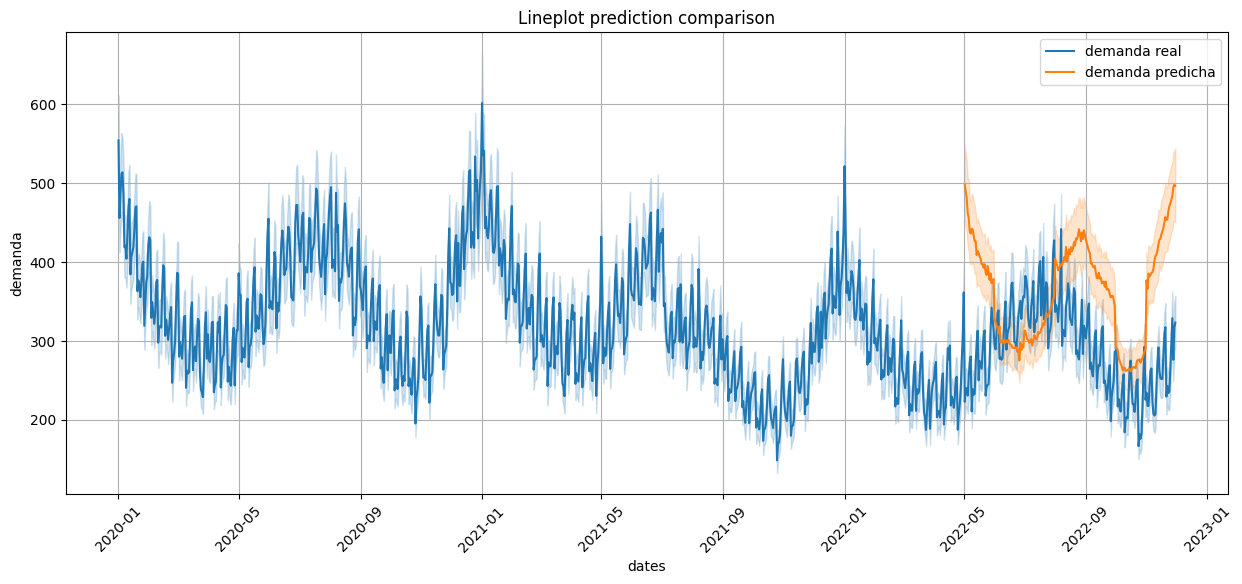

In [ ]:

plt.figure(figsize=(15, 6))
sns.lineplot(x="date", y="demanda", data=df_demand_train,label="demanda real")
sns.lineplot(x="date", y="demanda_pred", data=test_lstm,label="demanda predicha")
plt.title(f"Lineplot prediction comparison")
plt.xlabel("dates")
plt.ylabel("demanda")
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [ ]:
rmse_lstm = compute_rmse(test_lstm)
rmse_lstm

159.44623620660883

In [ ]:
rmse_lstm
lstm_model.save(f'saved_models/lstm_{rmse_lstm:0.2f}.keras')

### XGBoost Approach

In [38]:
lag_days = (df_demand_test.date.max() - df_demand_test.date.min()).days # lag = # de días que habrá en el Test Set REAL

target_map = df_demand_train[["date", "demanda"]].set_index("date").demanda.to_dict()
df_demand_train[f"demanda_{lag_days}_days_lag"] = (df_demand_train.date-pd.Timedelta(f'{lag_days} days')).map(target_map) # Prediction limited to 1 year
df_demand_train[f"demanda_{lag_days*2}_days_lag"] = (df_demand_train.date-pd.Timedelta(f'{lag_days*2} days')).map(target_map)
df_demand_train[f"demanda_{lag_days*3}_days_lag"] = (df_demand_train.date-pd.Timedelta(f'{lag_days*3} days')).map(target_map)

#### Cross-validation

In [58]:
def format_data(df_orig):
    df = df_orig.copy()

    df["categoria_subcategoria"] = df.categoria.astype(str)+"_"+df.subcategoria.astype(str)

    df.year = df.date.dt.year
    df.month = df.date.dt.month
    df.day = df.date.dt.day
    dummies_id_producto = pd.get_dummies(df.id_producto)
    dummies_tamano = pd.get_dummies(df.tamaño)
    dummies_categoria_subcategoria = pd.get_dummies(df.categoria_subcategoria)

    df = pd.concat([df,dummies_id_producto,dummies_tamano,dummies_categoria_subcategoria],axis=1)

    dummies_id_producto_cols = dummies_id_producto.columns
    dummies_tamano_cols = dummies_tamano.columns
    dummies_categoria_subcategoria_cols = dummies_categoria_subcategoria.columns
    vars = ["year","month","day","after_competition","premium","marca_exclusiva","estacional","demanda_89_days_lag","demanda_178_days_lag","demanda_267_days_lag"]
    vars = vars+list(dummies_id_producto_cols)+list(dummies_tamano_cols)+list(dummies_categoria_subcategoria_cols)

    x_df = df[vars]
    y_df = df["demanda"]
    return x_df, y_df

In [102]:
X,Y = format_data(df_demand_train)

tss = TimeSeriesSplit(n_splits=5,test_size=int(X.shape[0]*.1),gap=int(X.shape[0]*.1))


In [89]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(X):
    
    X_train = X.iloc[train_idx]
    y_train = Y.iloc[train_idx]
    X_test = X.iloc[val_idx]
    y_test = Y.iloc[val_idx]


    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=5000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:354.16727
[100]	validation_0-rmse:178.80078
[200]	validation_0-rmse:153.01210
[300]	validation_0-rmse:150.42760
[400]	validation_0-rmse:148.19061
[500]	validation_0-rmse:144.92649
[600]	validation_0-rmse:142.00069
[700]	validation_0-rmse:139.12252
[800]	validation_0-rmse:136.64237
[900]	validation_0-rmse:134.24116
[1000]	validation_0-rmse:131.95132
[1100]	validation_0-rmse:129.66404
[1200]	validation_0-rmse:127.81868
[1300]	validation_0-rmse:126.16505
[1400]	validation_0-rmse:124.87023
[1500]	validation_0-rmse:123.60061
[1600]	validation_0-rmse:122.37368
[1700]	validation_0-rmse:121.32525
[1800]	validation_0-rmse:120.26756
[1900]	validation_0-rmse:119.28501
[2000]	validation_0-rmse:118.45716
[2100]	validation_0-rmse:117.77917
[2200]	validation_0-rmse:117.12713
[2300]	validation_0-rmse:116.46515
[2400]	validation_0-rmse:116.03706
[2500]	validation_0-rmse:115.65965
[2600]	validation_0-rmse:115.27702
[2700]	validation_0-rmse:114.95155
[2800]	validation_0-rmse:114.899

In [103]:
X["demanda_pred"] = reg.predict(X)
X['date'] = pd.to_datetime(X[['year', 'month', 'day']])
X["demanda"] = Y

X

,year,month,day,after_competition,premium,marca_exclusiva,estacional,demanda_89_days_lag,demanda_178_days_lag,demanda_267_days_lag,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,pequeño,mediano,grande,aseo_,aseo_cuidado_personal,aseo_limpieza_general,bebidas_,bebidas_agua,bebidas_cerveza_internacional,bebidas_cerveza_nacional,bebidas_gaseosa,bebidas_licor_nacional,bebidas_vinos,carnes_y_aves_,carnes_y_aves_cerdo,carnes_y_aves_pavo,carnes_y_aves_pollo,carnes_y_aves_res,cereales_y_productos_secos_arroz,cereales_y_productos_secos_frutos_secos,cereales_y_productos_secos_legumbres,cereales_y_productos_secos_pasta,congelados_,congelados_helados,congelados_vegetales,frutas_y_verduras_,frutas_y_verduras_enlatadas,frutas_y_verduras_frescas,jabones_antibacterial,panaderia_y_panificados_,panaderia_y_panificados_integral,panaderia_y_panificados_otros,productos_enlatados_y_alimentos_envasados_,productos_lacteos_,productos_lacteos_crema,productos_lacteos_leche,productos_lacteos_queso,productos_lacteos_yogur,shampoos_,shampoos_acondicionador,shampoos_hidratante,demanda_pred,date,demanda
0,2020,1,1,False,False,True,False,NaN,NaN,NaN,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,727.869385,2020-01-01,869
1,2020,1,1,False,False,True,True,NaN,NaN,NaN,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,440.541321,2020-01-01,407
2,2020,1,1,False,False,True,False,NaN,NaN,NaN,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

In [105]:
compute_rmse(X)

71.29817059248153

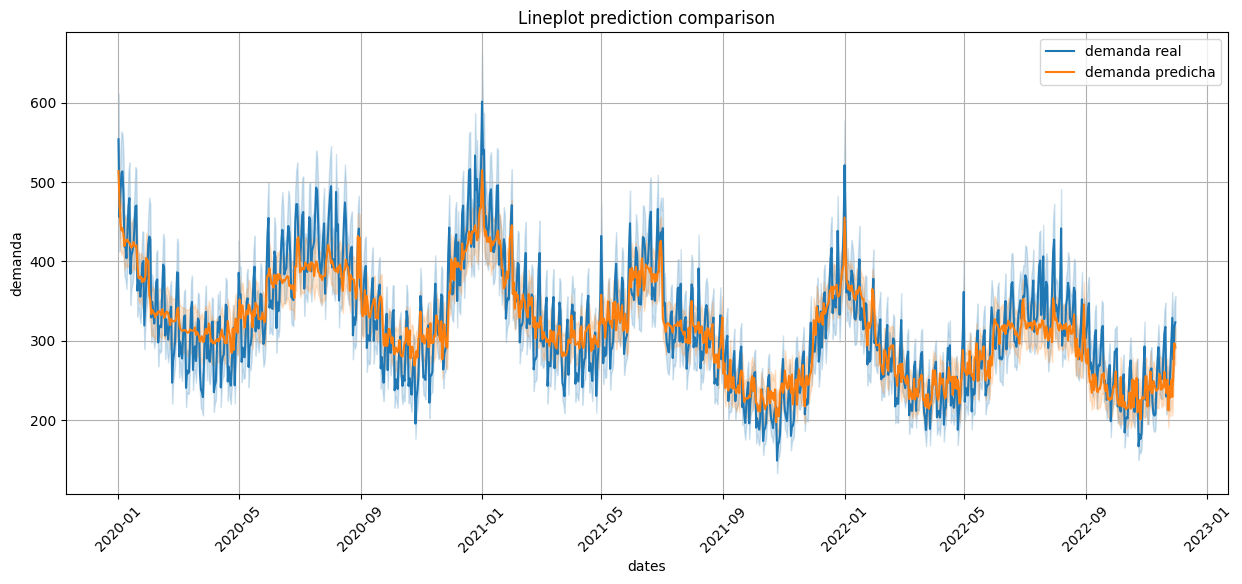

In [104]:
plt.figure(figsize=(15, 6))
sns.lineplot(x="date", y="demanda", data=X,label="demanda real")
sns.lineplot(x="date", y="demanda_pred", data=X,label="demanda predicha")
plt.title(f"Lineplot prediction comparison")
plt.xlabel("dates")
plt.ylabel("demanda")
plt.xticks(rotation=45)
plt.grid()
plt.show()

### Ensemble Models 

Re entrenamiento de los modelos con los registros completos

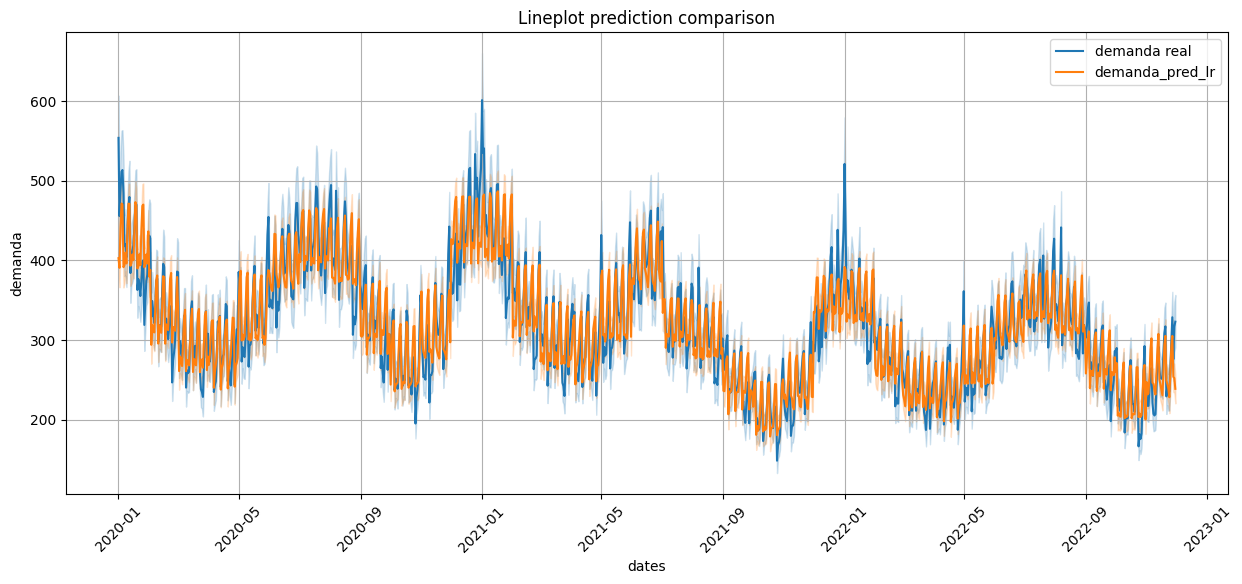

In [ ]:
full_data = pd.concat([train,test])

# Linear Model
linear_model = sm.ols(formula = formula, data = full_data)
fitted_linear_model = linear_model.fit()
full_data["demanda_pred"] = fitted_linear_model.predict(full_data)
plt.figure(figsize=(15, 6))
sns.lineplot(x="date", y="demanda", data=full_data,label="demanda real")
sns.lineplot(x="date", y="demanda_pred", data=full_data,label="demanda_pred_lr")
plt.title(f"Lineplot prediction comparison")
plt.xlabel("dates")
plt.ylabel("demanda")
plt.xticks(rotation=45)
plt.grid()
plt.show()
rmse_lm = compute_rmse(test_lm)
with open(f'saved_models/total_lm_{rmse_lm:0.2f}.pkl', 'wb') as f:
    pickle.dump(fitted_linear_model, f)


Epoch 1/10
3952/3952 ━━━━━━━━━━━━━━━━━━━━ 79s 19ms/step - loss: 24211.4004 - learning_rate: 0.0010
Epoch 2/10
3952/3952 ━━━━━━━━━━━━━━━━━━━━ 78s 20ms/step - loss: 7116.3301 - learning_rate: 0.0010
Epoch 3/10
3952/3952 ━━━━━━━━━━━━━━━━━━━━ 79s 20ms/step - loss: 5342.7783 - learning_rate: 0.0010
Epoch 4/10
3952/3952 ━━━━━━━━━━━━━━━━━━━━ 80s 20ms/step - loss: 4065.9268 - learning_rate: 0.0010
Epoch 5/10
3952/3952 ━━━━━━━━━━━━━━━━━━━━ 75s 19ms/step - loss: 3171.6584 - learning_rate: 0.0010
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.
3952/3952 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step


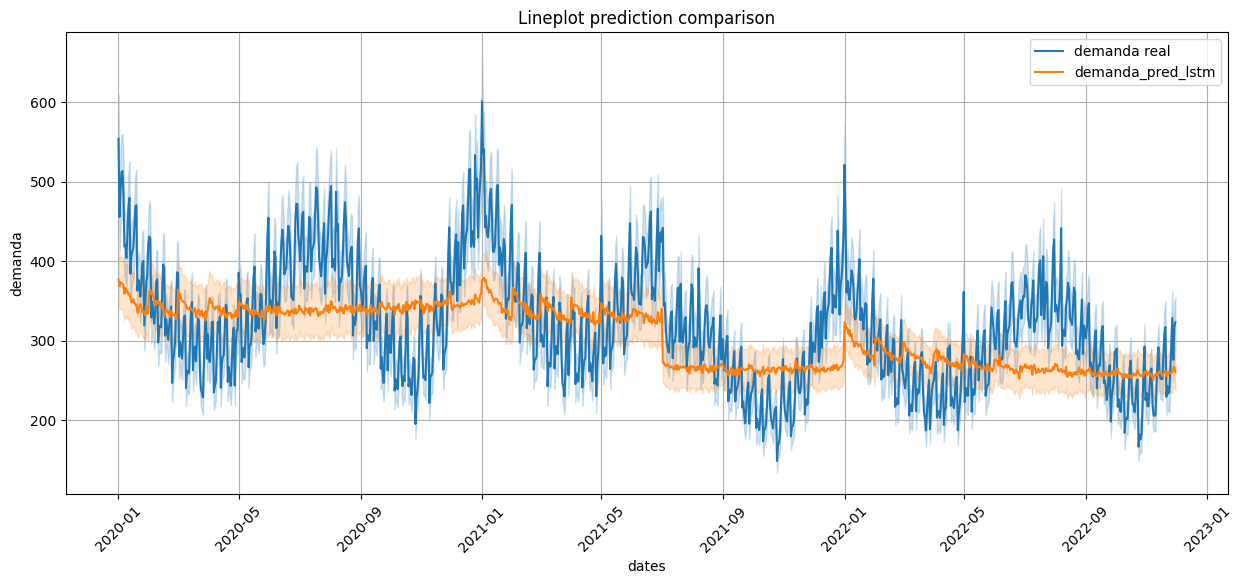

In [ ]:

# LSTM
x_full_data_lstm, num_vars = format_data(full_data)
y_full_data_lstm = full_data[["demanda"]].values
num_obs = x_full_data_lstm.shape[1]
lstm_model = create_lstm_model((num_obs, num_vars))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(x_full_data_lstm, y_full_data_lstm, batch_size = 32, epochs=1,shuffle=True,callbacks=[reduce_lr, early_stopping])
full_data["demanda_pred"] = lstm_model.predict(x_full_data_lstm)
plt.figure(figsize=(15, 6))
sns.lineplot(x="date", y="demanda", data=full_data,label="demanda real")
sns.lineplot(x="date", y="demanda_pred", data=full_data,label="demanda_pred_lstm")
plt.title(f"Lineplot prediction comparison")
plt.xlabel("dates")
plt.ylabel("demanda")
plt.xticks(rotation=45)
plt.grid()
plt.show()
rmse_lstm = compute_rmse(test_lstm)
lstm_model.save(f'saved_models/total_lstm_{rmse_lstm:0.2f}.keras')

In [ ]:
# Linear Regression + LSTM

with open('saved_models/total_lm_138.66.pkl', 'rb') as f:
    model_lr = pickle.load(f)

model_lstm = tf.keras.models.load_model('saved_models/total_lstm_133.07.keras')

full_data_lm_lstm = full_data.copy()
full_data_lm_lstm["demanda_pred_lm"] = model_lr.predict(full_data_lm_lstm)

x_full_data_lstm, _ = format_data(full_data_lm_lstm)
full_data_lm_lstm["demanda_pred_lstm"] = model_lstm.predict(x_full_data_lstm)

full_data_lm_lstm["demanda_pred"] = (full_data_lm_lstm["demanda_pred_lstm"]+full_data_lm_lstm["demanda_pred_lm"])/2
rmse_lm_lstm = compute_rmse(full_data_lm_lstm)
rmse_lm_lstm

3952/3952 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step


81.14574216871141

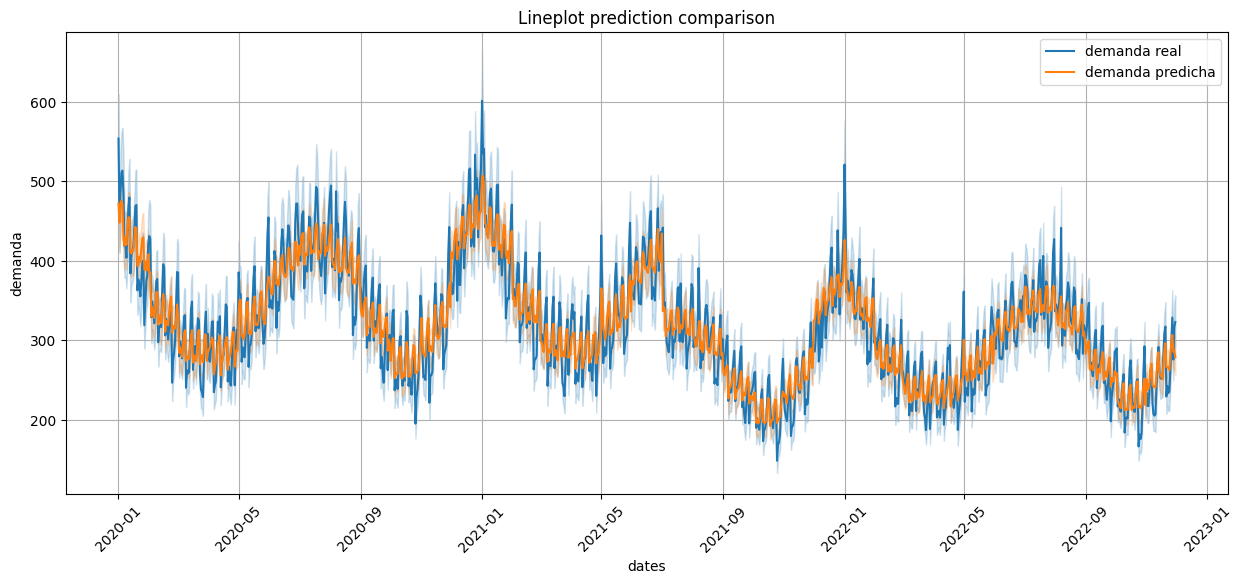

In [ ]:
plt.figure(figsize=(15, 6))
sns.lineplot(x="date", y="demanda", data=df_demand_train,label="demanda real")
sns.lineplot(x="date", y="demanda_pred", data=full_data_lm_lstm,label="demanda predicha")
plt.title(f"Lineplot prediction comparison")
plt.xlabel("dates")
plt.ylabel("demanda")
plt.xticks(rotation=45)
plt.grid()
plt.show()

# FINAL TEST

In [ ]:
df_demand_test["year"] = df_demand_test.date.dt.year
df_demand_test["month"] = df_demand_test.date.dt.month_name()
month_order = ('January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December')
df_demand_test["month"] = pd.Categorical(df_demand_test.date.dt.month_name(), categories=month_order, ordered=True)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_demand_test["day"] = pd.Categorical(df_demand_test.date.dt.day_name(), categories=day_order, ordered=True)

df_demand_test["after_competition"] = df_demand_test.date>=date_competition
df_demand_test["categoria_subcategoria"] = df_demand_test.categoria.astype(str)+"_"+df_demand_test.subcategoria.astype(str)

In [ ]:
df_demand_test["demanda_pred_lm"] = model_lr.predict(df_demand_test)

In [ ]:
x_demand_test_lstm, _ = format_data(df_demand_test)
df_demand_test["demanda_pred_lstm"] = model_lstm.predict(x_demand_test_lstm)

369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


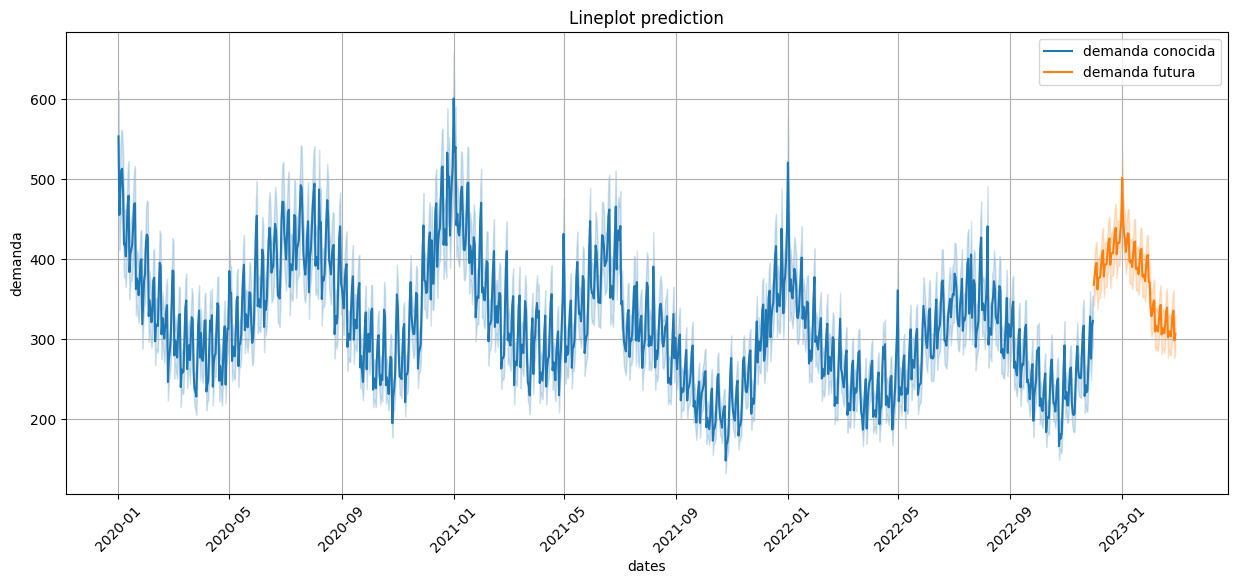

In [ ]:
df_demand_test["demanda_pred"] = (df_demand_test["demanda_pred_lstm"]+df_demand_test["demanda_pred_lm"])/2
plt.figure(figsize=(15, 6))
sns.lineplot(x="date", y="demanda", data=df_demand_train,label="demanda conocida")
sns.lineplot(x="date", y="demanda_pred", data=df_demand_test,label="demanda futura")
plt.title(f"Lineplot prediction")
plt.xlabel("dates")
plt.ylabel("demanda")
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [ ]:
to_csv_df = df_demand_test[["date", "id_producto" ,"demanda_pred"]].rename(columns={"demanda_pred":"demanda"})
to_csv_df

,date,id_producto,demanda
0,2022-12-01,1,275.692503
1,2022-12-01,2,422.922755
2,2022-12-01,3,567.512808
3,2022-12-01,4,246.269099
4,2022-12-01,5,195.269033
...,...,...,...
11781,2023-02-28,131,149.675646
11782,2023-02-28,132,351.874953
11783,2023-02-28,133,147.938006
11784,2023-02-28,134,405.489304


In [ ]:
to_csv_df.to_csv("resultado_prueba.csv")